# Logistic Regression

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
train = pd.read_csv("../data/thorax_and_wing_mdi_train.csv")
test = pd.read_csv("../data/thorax_and_wing_mdi_test.csv")

predictors = [c for c in train.columns if c != "Species"]

X_train, y_train = train[predictors].to_numpy(), train["Species"].to_numpy()
X_test, y_test = test[predictors].to_numpy(), test["Species"].to_numpy()

print("Train dataset:", X_train.shape, y_train.shape)
print("Test dataset:", X_test.shape, y_test.shape)

Train dataset: (1211, 14) (1211,)
Test dataset: (519, 14) (519,)


We can try some different regularisation schemes - specifically, both $L_1$ and $L_2$ penalty - to see which one performs better. $L_1$ penalty has the tendency to give us sparse solutions (TODO: explain why), that is it sets some predictor coefficients to zero. This can be helpful for interpretability and can give an idea of which predictors are most important in determining species type.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

clf_no_reg = LogisticRegression(random_state=42, max_iter=1000, penalty=None, solver='newton-cg')
clf_no_reg.fit(X_train, y_train)

clf_l1 = LogisticRegression(random_state=42, max_iter=1000, penalty='l1', solver='liblinear')
clf_l2 = LogisticRegression(random_state=42, max_iter=1000, penalty='l2', solver='newton-cg')

parameters = {"C": 1 / np.arange(0.1, 5.1, 0.1)}
grid_search_l1 = GridSearchCV(clf_l1, parameters)
grid_search_l2 = GridSearchCV(clf_l2, parameters)
grid_search_l1.fit(X_train, y_train)
grid_search_l2.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42,
                                          solver='newton-cg'),
             param_grid={'C': array([10.        ,  5.        ,  3.33333333,  2.5       ,  2.        ,
        1.66666667,  1.42857143,  1.25      ,  1.11111111,  1.        ,
        0.90909091,  0.83333333,  0.76923077,  0.71428571,  0.66666667,
        0.625     ,  0.58823529,  0.55555556,  0.52631579,  0.5       ,
        0.47619048,  0.45454545,  0.43478261,  0.41666667,  0.4       ,
        0.38461538,  0.37037037,  0.35714286,  0.34482759,  0.33333333,
        0.32258065,  0.3125    ,  0.3030303 ,  0.29411765,  0.28571429,
        0.27777778,  0.27027027,  0.26315789,  0.25641026,  0.25      ,
        0.24390244,  0.23809524,  0.23255814,  0.22727273,  0.22222222,
        0.2173913 ,  0.21276596,  0.20833333,  0.20408163,  0.2       ])})

In [4]:
print("L1 best params       :", grid_search_l1.best_params_)
print("L1 best mean CV score:", grid_search_l1.best_score_)
print("L2 best params       :", grid_search_l2.best_params_)
print("L2 best mean CV score:", grid_search_l2.best_score_)

L1 best params       : {'C': 5.0}
L1 best mean CV score: 0.8175016154814134
L2 best params       : {'C': 10.0}
L2 best mean CV score: 0.788596401727715


In [5]:
clf_l1 = LogisticRegression(random_state=42, max_iter=1000, penalty='l1', C=grid_search_l1.best_params_["C"], solver='liblinear')
clf_l1.fit(X_train, y_train)
clf_l2 = LogisticRegression(random_state=42, max_iter=1000, penalty='l2', C=grid_search_l2.best_params_["C"], solver='newton-cg')
clf_l2.fit(X_train, y_train)

LogisticRegression(C=10.0, max_iter=1000, random_state=42, solver='newton-cg')

None classifier
Training accuracy: 0.824
Test accuracy    : 0.794
l1 classifier
Training accuracy: 0.822
Test accuracy    : 0.786
l2 classifier
Training accuracy: 0.802
Test accuracy    : 0.771


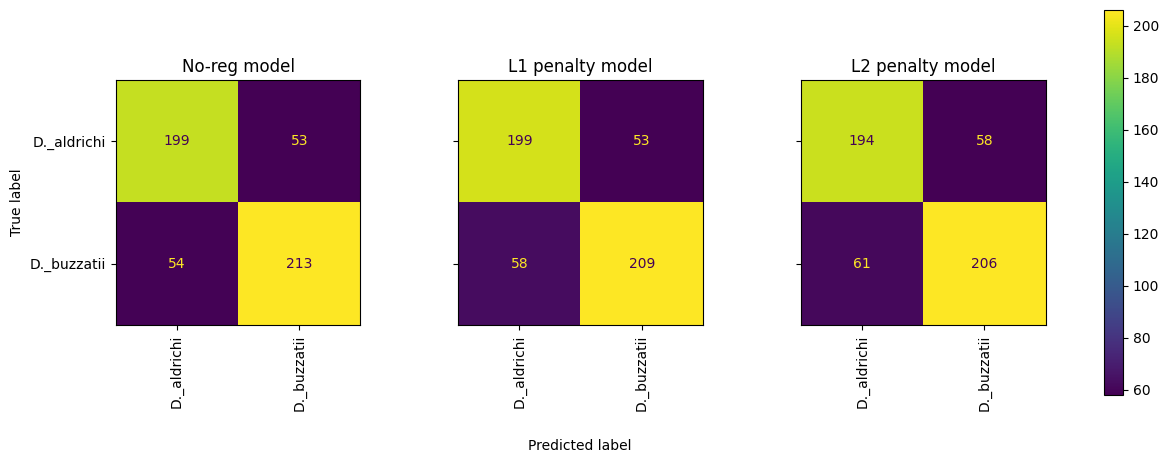

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,5))
titles = ("No-reg model", "L1 penalty model", "L2 penalty model")
for i, clf in enumerate((clf_no_reg, clf_l1, clf_l2)):
    print(clf.penalty, "classifier")
    train_preds = clf.predict(X_train)
    test_preds = clf.predict(X_test)
    print("Training accuracy:", round(accuracy_score(y_train, train_preds), 3))
    print("Test accuracy    :", round(accuracy_score(y_test, test_preds), 3))

    cm = confusion_matrix(y_test, test_preds, labels=clf_no_reg.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_no_reg.classes_)
    disp.plot(ax=ax[i], xticks_rotation=90)
    disp.ax_.set_title(titles[i])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel("")
    if i != 0:
        disp.ax_.set_ylabel("")
plt.subplots_adjust(wspace=0.40, hspace=0.1)
fig.text(0.4, 0, 'Predicted label', ha='left')
fig.colorbar(disp.im_, ax=ax)
plt.savefig("../fig/cm_logreg.png")
plt.show()

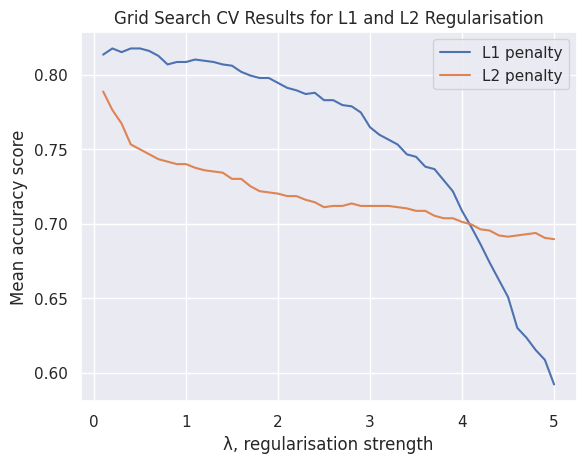

In [7]:
sns.set()
l1_scores = grid_search_l1.cv_results_["mean_test_score"]
l2_scores = grid_search_l2.cv_results_["mean_test_score"]
lambda_values = 1 / grid_search_l2.cv_results_["param_C"].data

fig, ax = plt.subplots()
ax.plot(lambda_values, l1_scores, label="L1 penalty")
ax.plot(lambda_values, l2_scores, label="L2 penalty")
ax.set_title("Grid Search CV Results for L1 and L2 Regularisation")
ax.set_xlabel("λ, regularisation strength")
ax.set_ylabel("Mean accuracy score")
plt.legend()
plt.savefig("../fig/grid_search_cv_l1_l2_logreg.png")
plt.show()

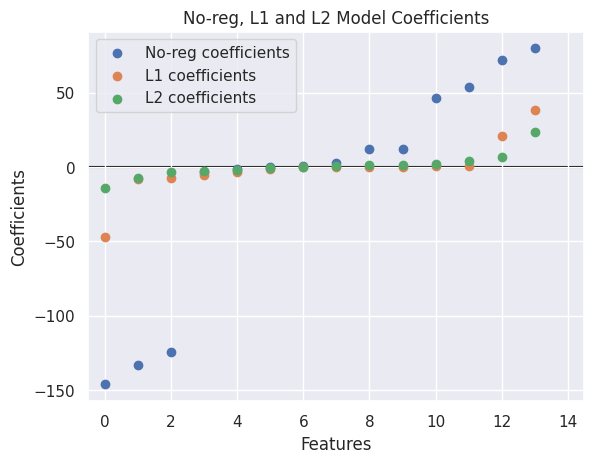

In [8]:
fig, ax = plt.subplots()
n_pred = len(predictors)
ax.plot(np.arange(-1, n_pred + 2, 1), np.zeros(n_pred + 3), color='black', zorder=-1)
ax.scatter(range(n_pred), sorted(clf_no_reg.coef_[0]), label="No-reg coefficients")
ax.scatter(range(n_pred), sorted(clf_l1.coef_[0]), label="L1 coefficients")
ax.scatter(range(n_pred), sorted(clf_l2.coef_[0]), label="L2 coefficients")
ax.set_title("No-reg, L1 and L2 Model Coefficients")
ax.set_xlabel("Features")
ax.set_ylabel("Coefficients")
ax.set_xlim(-0.5, 14.5)
plt.legend()
plt.savefig("../fig/coef_logreg.png")
plt.show()

In [9]:
print(np.array(predictors)[np.isclose(clf_no_reg.coef_, 0).reshape(-1)])
print(np.array(predictors)[np.isclose(clf_l1.coef_, 0).reshape(-1)])
print(np.array(predictors)[np.isclose(clf_l2.coef_, 0).reshape(-1)])

[]
['lpd' 'l3' 'w3']
[]
